In [1]:
# Creo il DataFrame
import pandas as pd
from MJP.majority_portfolio_utilities_TV import * 
import os

FILENAME = 'monthly_data.csv'
factors_df=pd.DataFrame({
    'factors': ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc'],
    'signs': [  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.],
    'wsigns':[  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.]
})

DATA_INIZIO = '2000-01-01'
DATA_FINE = '2023-12-31'

df = create_df(FILENAME, factors_df['factors'].tolist(), DATA_INIZIO, DATA_FINE) # funzione sua 
print(f"DataFrame caricato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
df.head()

DataFrame caricato: 565,488 righe, 19 colonne


,PERMNO,date,RET,ns,me,size,me_lag,ag,gp,acc,bm,RF,Mkt_RF,RET_RF,cumret,dolvol6,ill6,volatility,beta
0,10001,2000-01-31,-0.044118,0.011907,19.90625,2.991034,20.82500,0.019392,0.11407,-0.069426,0.880980,0.0041,-0.0474,-0.048218,-0.066220,3862.520833,0.000010,0.044107,0.236349
1,10001,2000-02-29,0.015385,0.011907,20.21250,3.006301,19.90625,0.019392,0.11407,-0.069426,0.867631,0.0043,0.0245,0.011085,-0.018159,3476.520833,0.000011,0.036709,0.237646
2,10001,2000-03-31,-0.015758,0.017605,19.71200,2.981228,20.21250,0.019392,0.11407,-0.069426,0.889661,0.0047,0.0520,-0.020458,-0.015986,3445.854167,0.000009,0.036743,0.245249
3,10001,2000-04-30,0.011719,0.017605,19.94300,2.992878,19.71200,0.019392,0.11407,-0.069426,0.879356,0.0046,-0.0640,0.007119,-0.045133,3282.276042,0.000005,0.036655,0.223433
4,10001,2000-05-31,-0.023166,0.017605,19.48100,2.969440,19.94300,0.019392,0.11407,-0.069426,0.900210,0.0050,-0.0442,-0.028166,-0.013093,2921.385417,0.000007,0.036747,0.240957


In [2]:
# Normalizzo il df tramite quantile-normalization
from sklearn.preprocessing import QuantileTransformer

col_to_norm = [col for col in df.columns if col not in ['PERMNO', 'date']]
df = df.dropna(subset=col_to_norm)


scaler = QuantileTransformer(output_distribution='uniform', random_state=0)
df_norm = df.copy()
df_norm[col_to_norm] = scaler.fit_transform(df[col_to_norm])

print('df normalizzato! ')
df_norm.head()

df normalizzato! 


,PERMNO,date,RET,ns,me,size,me_lag,ag,gp,acc,bm,RF,Mkt_RF,RET_RF,cumret,dolvol6,ill6,volatility,beta
0,10001,2000-01-31,0.315972,0.592934,0.080338,0.080340,0.083577,0.420856,0.187697,0.088962,0.753351,0.878879,0.146647,0.307592,0.377610,0.046409,0.883548,0.059268,0.114614
1,10001,2000-02-29,0.551452,0.592934,0.081378,0.081379,0.080621,0.420856,0.187697,0.088962,0.746632,0.911912,0.652152,0.539514,0.423905,0.042785,0.890995,0.024581,0.115027
2,10001,2000-03-31,0.415576,0.655555,0.079641,0.079643,0.081429,0.420856,0.187697,0.088962,0.756419,0.950951,0.871872,0.403195,0.426039,0.042352,0.880450,0.024667,0.117714
3,10001,2000-04-30,0.536712,0.655555,0.080469,0.080471,0.079903,0.420856,0.187697,0.088962,0.752640,0.943443,0.097097,0.523892,0.397260,0.040335,0.842951,0.024445,0.111163
4,10001,2000-05-31,0.388465,0.655555,0.078897,0.078899,0.080737,0.420856,0.187697,0.088962,0.760330,0.970470,0.152653,0.376114,0.429324,0.035457,0.866483,0.024677,0.115888


In [3]:
# Creo portafoglio MJ
remove_outliers = False
inf, sup = None, None
MJ_configuration={
    'K' : 12, # holding_periods in months
    'lag' : 5, # 5 for june reallocation
    'factors' : factors_df['factors'].to_list(),
    'num_port' : 10, # number of portfolios
    'num_cat' : 6, # number of categorical variables to use per factor in mj #'num_cat': 6
    'weighting': False,
    'verbose': True,
    'n_jobs':-1,
    'mj_window':1,
    'method' : 'majority', # mean_rank, majority, 75q, 90q, lex, dlex
    'rolling_method':'profile',  ###'rank','vote','profile'
    'treat_na_mj':'median',
    'remove_outliers':remove_outliers,
    'inclusive':True,
    'fix_signs':True, # True: tieni fisso il numero di votanti ed il loro segno
    'all_voters_not_nan_on_reallocation':True,
    #### PARAMETRI UTILIZZATI SOLO SE fix_signs=False ####
    'min_voters':5,    
    'voting_window':6,
    'sign_voting_window':12,
    'p_threshold' : 0.1, 
    'delta_utility' : 0,
    'eliminations': 1,
    'players_batch_size': 5,
    'small': True
}
if remove_outliers:
    MJ_configuration['outliers']=[inf,sup]

if MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['signs'].to_list()
    compute='mj'
elif not MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['wsigns'].to_list()
    compute='wmj'

factors=factors_df['factors'].to_list() # salva separatamente la lista dei nomi dei fattori 

In [ ]:
### COMPUTE SINGLE FACTOR STRATEGIES
portfolios, _, portfolios_stock_reallocation = compute_factor_strategies(df, MJ_configuration)
        # '2020-06-30': [list of tickers]       # Con pesi, uguale ma 'AAPL': 0.1           # 'AAPL': 2020-06-30': 'P3', '2021-06-30': 'P5'}
        # '2021-06-30': [list of tickers]
        # _ perché non considero weighted_portfolios al momento

### COMPUTE EQUAL WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=False
MJ_portfolios, \
mj_voters, \
MJ_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df, 
                                                            MJ_configuration)
portfolios['mj'] = MJ_portfolios['mj']
portfolios_stock_reallocation['mj'] = {}
portfolios_stock_reallocation['mj']['EW_turnover'] = MJ_portfolios_stock_reallocation['mj']

'''
portfolios = {
  'ns': DataFrame con port1...port10 costruiti su ns,
  'beta': ...,
  'bm': ...,
  ...
  'mj': DataFrame con port1...port10 creati con MJ
}
'''


/Users/nitroroot/Desktop/tesi/mcdm_4crit/VG/MJP/majority_portfolio_utilities_TV.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2000-01-31 00:00:00', '2000-02-29 00:00:00', '2000-03-31 00:00:00',
 '2000-04-30 00:00:00', '2000-05-31 00:00:00', '2000-06-30 00:00:00',
 '2000-07-31 00:00:00', '2000-08-31 00:00:00', '2000-09-30 00:00:00',
 '2000-10-31 00:00:00',
 ...
 '2003-01-31 00:00:00', '2003-02-28 00:00:00', '2003-03-31 00:00:00',
 '2003-04-30 00:00:00', '2003-05-31 00:00:00', '2003-06-30 00:00:00',
 '2003-07-31 00:00:00', '2003-08-31 00:00:00', '2003-09-30 00:00:00',
 '2003-10-31 00:00:00']
Length: 468013, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:,'medate'] = df.loc[:,'date'].copy() + pd.offsets.MonthEnd(0)
/Users/nitroroot/Desktop/tesi/mcdm_4crit/VG/MJP/majority_portfolio_utilities_TV.py:89: FutureWarnin

<Axes: xlabel='medate'>

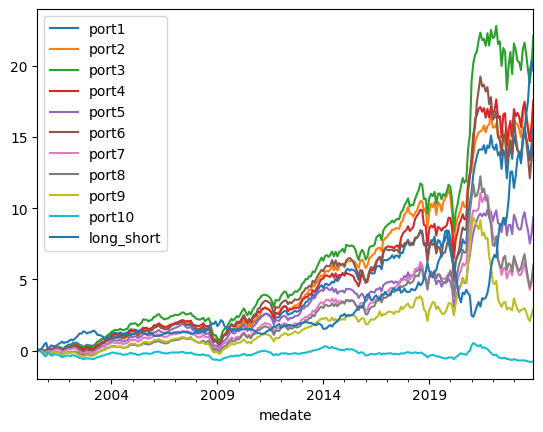

In [ ]:
#PLOT THE RESULTS OF SINGLA FACTOR SORTING FOR A GIVEN FACTOR

import matplotlib.pyplot as plt

factor='ns'
((1+portfolios[factor]).cumprod()-1).plot()

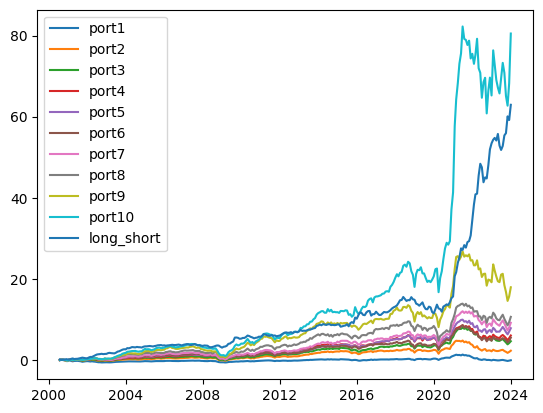

In [10]:
# Plot cumulative returns of EW MJ portfolios 
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['mj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

Io creo un file di configurazione, in cui specifico soprattuto numero di portafogli e fattori. 
Dopo di cio, passando la configurazione alla funzione compute_factor_strategy, creo i portafogli basati sul singolo criterio.
quanti portafogli per ogni criterio? Sono 10 + il long-short, per ogni criterio? 
Dopo di questo, con la funzione seguente, creo i 10 portafogli + long-short basati su MJ (quindi tutti i criteri precedertni danno un voto per riassumere). 
Fatto cio, creo un dizionario con tutti i portafogli creati, a cui aggiungo i portafogli creati con MJ. 
Seconda domanda: Creo un dizionario con chiave criterio o mj, e ad ogni chiave associo un dataframe con i 10+1 portafogli?

Detto cio, plotto i 10+1 portafogli con 'ns', e dopo di cio faccio uguale con mj?
è questo quello che faccio?